
# Robust Autonomous Driving Decision Making
Mehtan Rahman and Mohammad N. Kashif

May 1, 2025

CS 378, Geometric Foundations of Data Science

Prof. Chandrajit Bajaj

University of Texas at Austin

# Setup

Pre-import work to avoid warnings and errors

In [ ]:
# Fix NumPy, Protobuf, and Docopt
!pip install -q numpy==2.0.0 protobuf>=5.31.0 docopt

# Install highway-env from GitHub
!pip install --user git+https://github.com/eleurent/highway-env

# Fix sys.path to include --user installs
import sys
sys.path.append("/root/.local/lib/python3.11/site-packages")

  Cloning https://github.com/eleurent/highway-env to /tmp/pip-req-build-kvyya11v
  Running command git clone --filter=blob:none --quiet https://github.com/eleurent/highway-env /tmp/pip-req-build-kvyya11v
  Resolved https://github.com/eleurent/highway-env to commit c7c12cc30bd5a255cb846d7f7a875589bbf3684e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Clone rl-agents repo
%cd /content
!rm -rf rl-agents
!git clone --depth=1 https://github.com/eleurent/rl-agents.git

# Patch logger.py and evaluation.py
from pathlib import Path

logger_path = Path("/content/rl-agents/rl_agents/trainer/logger.py")
logger_text = logger_path.read_text()
logger_text = logger_text.replace("gym_level=gym.logger.INFO", "gym_level=__import__('logging').INFO")
logger_lines = [line for line in logger_text.splitlines() if "gym.logger.set" not in line]
logger_path.write_text("\n".join(logger_lines))

eval_path = Path("/content/rl-agents/rl_agents/trainer/evaluation.py")
eval_text = eval_path.read_text()
eval_text = eval_text.replace("np.infty", "np.inf")
eval_text = eval_text.replace(
    "from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics, capped_cubic_video_schedule",
    "from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics"
)

inject_fn = """
def capped_cubic_video_schedule(episode_id):
    return True
"""
eval_lines = eval_text.splitlines()
for i, line in enumerate(eval_lines):
    if not line.strip().startswith("import") and not line.strip().startswith("from"):
        inject_index = i
        break
eval_lines = eval_lines[:inject_index] + [inject_fn.strip()] + eval_lines[inject_index:]
eval_path.write_text("\n".join(eval_lines))

/content
Cloning into 'rl-agents'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 397 (delta 102), reused 237 (delta 63), pack-reused 0 (from 0)
Receiving objects: 100% (397/397), 186.89 KiB | 10.99 MiB/s, done.
Resolving deltas: 100% (102/102), done.


16612

In [ ]:
# Patch rl-agents to avoid using tensorboardX
from pathlib import Path

eval_path = Path("/content/rl-agents/rl_agents/trainer/evaluation.py")
eval_code = eval_path.read_text()
eval_code = eval_code.replace("from tensorboardX import SummaryWriter", "SummaryWriter = lambda *a, **kw: None")
eval_code = eval_code.replace("self.writer = SummaryWriter(log_dir=str(self.result_path))", "self.writer = None")

eval_path.write_text(eval_code)
print("tensorboardX disabled – agent will run without logging.")


tensorboardX disabled – agent will run without logging.


Necessary Imports

In [ ]:
import sys
sys.path.append("/content/rl-agents")
import os

import gymnasium as gym
import highway_env

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import copy
from collections import namedtuple, defaultdict, deque
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import trange
import random, yaml, tempfile, pathlib
import wandb
import cv2
from base64 import b64encode

from highway_env import utils, envs
from gymnasium import ObservationWrapper, Wrapper
from rl_agents.trainer.evaluation import Evaluation
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML, clear_output, display
from PIL import Image

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Missing tools for video display

In [ ]:
!pip install -q pyvirtualdisplay
!apt-get -y install xvfb ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%cd /content
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
%cd /content/HighwayEnv/scripts/

import sys
sys.path.append("/content/HighwayEnv/scripts")

from utils import record_videos, show_videos

/content
/content/HighwayEnv/scripts


Warning message patch

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Helper Functions/Classes

**Gaussian additive noise wrapper:** Makes the agent more robust by simulating sensor noise

In [ ]:
class NoisyObservation(ObservationWrapper):
    def __init__(self, env, std_dev):
        super().__init__(env)
        self.std_dev = std_dev

    def observation(self, obs):
        # Unpack if needed
        if isinstance(obs, tuple):
            obs = obs[0]

        obs = np.array(obs)  # make a writable copy
        obs[:, 3:5] += np.random.normal(0, self.std_dev, size=obs[:, 3:5].shape)
        return obs


**Environment initialization:** Uses "highway-v0", wraps with NoisyObservation

In [ ]:
def make_env(env_name="highway-v0", noise_std=0.0):
    config = {
        "observation": {"type": "Kinematics"},
        "policy_frequency": 5,
        "simulation_frequency": 15,
        "duration": 40,
        "vehicles_count": 15,
        "screen_width": 600,
        "screen_height": 150,
        "show_trajectories": True,
        "render_agent": True
    }
    env = gym.make(env_name, config=config, render_mode="rgb_array")
    if noise_std > 0.0:
        env = NoisyObservation(env, noise_std)
    return env

**Latest video display**

In [ ]:
from base64 import b64encode

def show_latest_video(path="videos"):
    files = sorted(os.listdir(path))
    for file in files:
        if file.endswith(".mp4"):
            mp4_path = os.path.join(path, file)
            break
    mp4 = open(mp4_path, 'rb').read()
    b64 = b64encode(mp4).decode()
    return HTML(f'<video width=640 controls><source src="data:video/mp4;base64,{b64}" type="video/mp4"></video>')


**Video Capturing:** Runs an agent in the environment until it completes an episode without crashing and records the video

In [ ]:
def record_and_show_successful_episode(make_env_fn, planner, video_folder="videos",
                                       max_steps=200, max_tries=10):
    # Check if the planner needs a `step` argument
    needs_step = 'step' in inspect.signature(planner.act).parameters

    env_vid = make_env_fn()
    env_vid = record_videos(env_vid, video_folder=video_folder)

    for attempt in range(1, max_tries + 1):
        obs = env_vid.reset()[0]
        done = False
        steps = 0

        while not done and steps < max_steps:
            if needs_step:
                action = planner.act(obs, steps)
            else:
                action = planner.act(obs)

            obs, r, term, trunc, _ = env_vid.step(action)
            done = term or trunc
            steps += 1

        if steps >= max_steps:
            print(f"[Attempt {attempt}] Success: survived {steps} steps.")
            break
        else:
            print(f"[Attempt {attempt}] Crashed at step {steps}, retrying...")

    env_vid.close()

    # Find and display the latest video
    video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")],
                         key=lambda f: os.path.getmtime(os.path.join(video_folder, f)))
    if not video_files:
        print(f"No video found in '{video_folder}'.")
        return

    latest = os.path.join(video_folder, video_files[-1])
    with open(latest, "rb") as f:
        encoded = b64encode(f.read()).decode()
    display(HTML(
        f'<video width=640 controls>'
        f'<source src="data:video/mp4;base64,{encoded}" type="video/mp4">'
        f'</video>'
    ))


**Metric Overlay Wrapper:** Superimposes total reward & collision count
    onto the rendered RGB frames.

In [ ]:
class MetricOverlayWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.total_reward    = 0.0
        self.collision_count = 0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.total_reward    = 0.0
        self.collision_count = 0
        return obs, info

    def step(self, action):
        obs, r, terminated, truncated, info = self.env.step(action)
        # update metrics
        self.total_reward += r
        if info.get("crashed", False) or info.get("collision", False):
            self.collision_count += 1
        # pass metrics along if you want
        info["total_reward"]    = self.total_reward
        info["collision_count"] = self.collision_count
        return obs, r, terminated, truncated, info

    def render(self, *args, **kwargs):
        frame = self.env.render(*args, **kwargs)

        # Ensure proper format
        if isinstance(frame, Image.Image):
            frame = np.array(frame.convert("RGB"))
        if frame.ndim == 2:
            frame = np.stack([frame]*3, axis=-1)
        if np.issubdtype(frame.dtype, np.floating):
            frame = np.clip(frame * 255, 0, 255).astype(np.uint8)

        # Fix: make frame contiguous in memory
        frame = np.ascontiguousarray(frame)

        # Add overlay
        text = f"Reward: {self.total_reward:.1f}  Collisions: {self.collision_count}"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 3)
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1)
        return frame


**Runs** multiple episodes of a planner in the environment and **displays** a real-time dashboard that tracks performance metrics.

In [ ]:
import inspect

def run_and_dashboard(make_env_fn, planner, episodes, max_steps, model_name):
    rewards = []
    collisions = []
    env = make_env_fn()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Check if planner.act requires a `step` argument
    needs_step = 'step' in inspect.signature(planner.act).parameters

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0
        collision_count = 0
        step = 0  # <- step value starts here, as before

        while not done and step < max_steps:
            if needs_step:
                action = planner.act(obs, step)
            else:
                action = planner.act(obs)

            obs, r, term, trunc, info = env.step(action)
            total_reward += r
            collision_count = info.get("collision_count", collision_count)
            done = term or trunc
            step += 1  # increment step for next loop

        rewards.append(total_reward)
        collisions.append(collision_count)

        clear_output(wait=True)
        ax1.clear(); ax2.clear()

        ax1.plot(range(1, ep + 1), rewards, marker='o')
        ax1.set_title(f"{model_name} - Episode Returns")
        ax1.set_xlabel("Episode"); ax1.set_ylabel("Return")

        ax2.plot(range(1, ep + 1), collisions, marker='o')
        ax2.set_title(f"{model_name} - Collisions")
        ax2.set_xlabel("Episode"); ax2.set_ylabel("Collision Count")

        display(fig)

    plt.close(fig)
    drop_rewards = rewards
    drop_collisions = collisions

**Trivial Planner** that samples actions from the wrapped env

In [ ]:
class RandomPlanner:
    def __init__(self, env_fn):
        self.env_fn = env_fn
    def act(self, obs):
        # sample from a fresh env to get the correct action_space
        return self.env_fn().action_space.sample()

# **Baseline:** Deterministic Robust Optimistic Planning

**Node** in the planning tree for Deterministic Robust Optimistic

In [ ]:
class TreeNode:
    def __init__(self, depth, parent=None, action=None):
        self.depth        = depth          # depth in the planning tree
        self.parent       = parent
        self.action       = action         # action taken to reach this node
        self.children     = []             # list of TreeNode
        self.u_r          = -np.inf        # worst-case return estimate at this node
        self.b_r          =  np.inf        # optimistic bound = u_r + bonus
    def is_leaf(self):
        return len(self.children)==0

**Sets up** parameters

In [ ]:
class DeterministicRobustOptimisticPlanner:
    def __init__(self, make_env_fn, horizon=3, budget=100, gamma=0.9, thetas=None):
        self.make_env_fn = make_env_fn
        self.H           = horizon
        self.B           = budget
        self.γ           = gamma
        self.thetas      = thetas or [None]

Performs **tree search planning** from the current state and returns the best first action.

In [ ]:
def act(self, obs):
    root = TreeNode(depth=0)
    root.u_r = 0.0
    root.b_r = 1.0/(1-self.γ)  # max possible
    # run B expansions
    for _ in range(self.B):
        leaf = self._select_leaf(root)
        if leaf.depth < self.H:
            self._expand(leaf, obs)
        self._backup(leaf)
    # choose child of root with largest b_r
    if not root.children:
        return 0
    best = max(root.children, key=lambda c: c.b_r)
    return best.action
DeterministicRobustOptimisticPlanner.act = act

**Greedily descends** from a node to a leaf with the highest b_r value

In [ ]:
def _select_leaf(self, node):
    if node.is_leaf():
        return node
    best = max(node.children, key=lambda c: c.b_r)
    return self._select_leaf(best)
DeterministicRobustOptimisticPlanner._select_leaf = _select_leaf

**Simulates** all possible actions from a leaf node and **adds new children to the planning tree.**

In [ ]:
def _expand(self, node, root_obs):
    for a in range(self.make_env_fn(self.thetas[0]).action_space.n):
        # worst‐case return across all θ
        returns = []
        for θ in self.thetas:
            env = self.make_env_fn(θ)
            obs = env.reset()  # resets to root_obs if you’ve stored env state there
            # replay path to `node` from root
            path = []
            cur = node
            while cur.parent is not None:
                path.append(cur.action)
                cur = cur.parent
            for act in reversed(path):
                obs, _, done, *_ = env.step(act)
            # now take action `a` at this leaf
            total, γt = 0.0, 1.0
            obs2, r, done, *_ = env.step(a)
            total += γt * r
            γt *= self.γ
            # simulate greedy default (action=0) until horizon
            for _ in range(node.depth+1, self.H):
                obs2, r, done, *_ = env.step(0)
                total += γt * r
                γt *= self.γ
                if done:
                    break
            returns.append(total)
        u_r = min(returns)
        # create child
        child = TreeNode(depth=node.depth+1, parent=node, action=a)
        child.u_r = u_r
        # optimistic bound: u_r + γ^(H−d)/(1−γ)
        child.b_r = u_r + (self.γ**(self.H - child.depth)) / (1 - self.γ)
        node.children.append(child)
DeterministicRobustOptimisticPlanner._expand = _expand

Propagates the best optimistic return (b_r) estimates up the tree from a newly expanded leaf.

In [ ]:
def _backup(self, node):
    while node.parent is not None:
        p = node.parent
        p.b_r = max(c.b_r for c in p.children)
        node = p
DeterministicRobustOptimisticPlanner._backup = _backup

Creates a DeterministicRobustOptimisticPlanner instance

In [ ]:
planner = DeterministicRobustOptimisticPlanner(
    make_env_fn=lambda θ: make_env(noise_std=θ),
    horizon=5,
    budget=500,
    gamma=0.9,
    thetas=[0.0,0.05,0.1]
)
env = make_env(noise_std=0.05)

**Executes the planner** in a moderately noisy environment

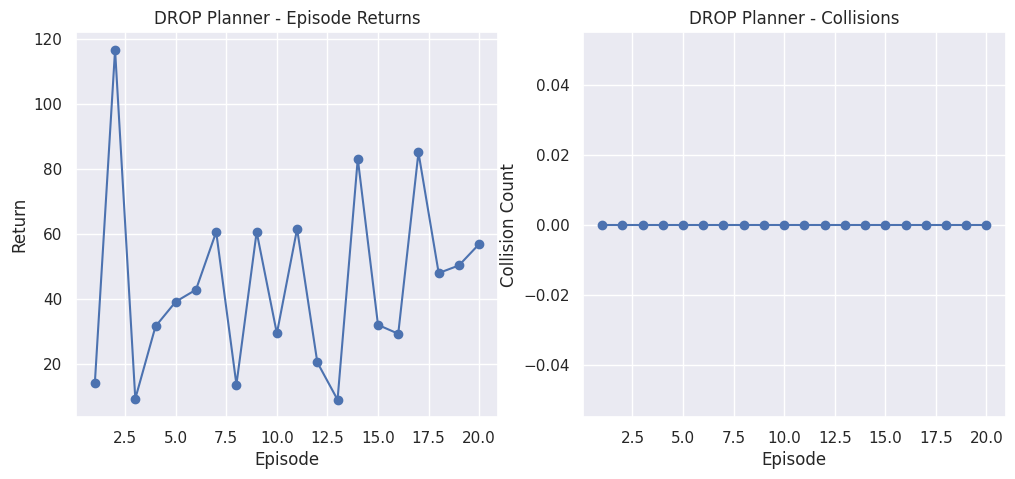

In [ ]:
run_and_dashboard(
    make_env_fn=lambda: make_env(noise_std=0.05),
    planner=planner,
    episodes=20,
    max_steps=200,
    model_name="DROP Planner"
)

**Video Demo:** Visualizes a successful episode using the video recorder.

In [ ]:
record_and_show_successful_episode(
    make_env_fn=lambda:
        MetricOverlayWrapper(make_env(noise_std=0.05)),
    planner=planner,              # your DeterministicRobustOptimisticPlanner instance
    video_folder="videos_drop",
    max_steps=200,                # e.g. 40s * 5 Hz = 200 steps
    max_tries=5
)

# **Secondary:** Interval-based Robust Control

Creates a robust gym environment wrapper that simulates two versions of the environment at extreme parameter values

In [ ]:
class IntervalWrapper(gym.Wrapper):
    def __init__(self, make_env_fn, theta_low, theta_high):
        # Create two env instances for the extremes
        self.env_low  = make_env_fn(theta_low)
        self.env_high = make_env_fn(theta_high)
        # We delegate metadata (action_space, etc.) to env_low
        super().__init__(self.env_low)

Resets both env_low and env_high to get their initial states

In [ ]:
def reset(self, **kwargs):
    # Grab obs and info from both extremes
    obs_low,  info_low  = self.env_low.reset(**kwargs)
    obs_high, info_high = self.env_high.reset(**kwargs)
    # Build your interval hull
    self.lo = obs_low.copy()
    self.hi = obs_high.copy()
    # Return ((lo, hi), info) so wrappers stay happy
    return (self.lo, self.hi), {}
IntervalWrapper.reset = reset;

Steps both env_low and env_high with the same actionS

In [ ]:
def step(self, action):
    # Step both envs with the same action
    obs_low,  r_low,  done_low,  trunc_low,  info_low  = self.env_low.step(action)
    obs_high, r_high, done_high, trunc_high, info_high = self.env_high.step(action)
    # Update interval hull to the new extrema
    self.lo = obs_low.copy()
    self.hi = obs_high.copy()
    # Worst-case reward
    r_robust = min(r_low, r_high)
    # Episode ends if either extreme ends
    terminated = done_low or done_high
    truncated  = trunc_low or trunc_high
    # Return 5-tuple: (obs, reward, terminated, truncated, info)
    return (self.lo, self.hi), min(r_low, r_high), terminated, truncated, {'low':info_low, 'high':info_high}
IntervalWrapper.step = step

Initializes an IntervalWrapper and an IntervalPlanner

In [ ]:
theta_low, theta_high = 0.0, 0.1
interval_env = IntervalWrapper(make_env_fn=lambda t: make_env(noise_std=t),
                               theta_low=theta_low, theta_high=theta_high)
class IntervalPlanner:
    def act(self, obs_tuple):
        obs_lo, obs_hi = obs_tuple
        vel_lo = obs_lo[0, 3]
        lateral_pos = obs_lo[0, 1]

        if vel_lo < 0.3:
            return 2  # Accelerate
        elif lateral_pos > 0.3:
            return 3  # Steer left
        elif lateral_pos < -0.3:
            return 1  # Steer right
        else:
            return 0  # Keep straight

interval_planner = IntervalPlanner()

**Executes the planner** in a moderately noisy environment

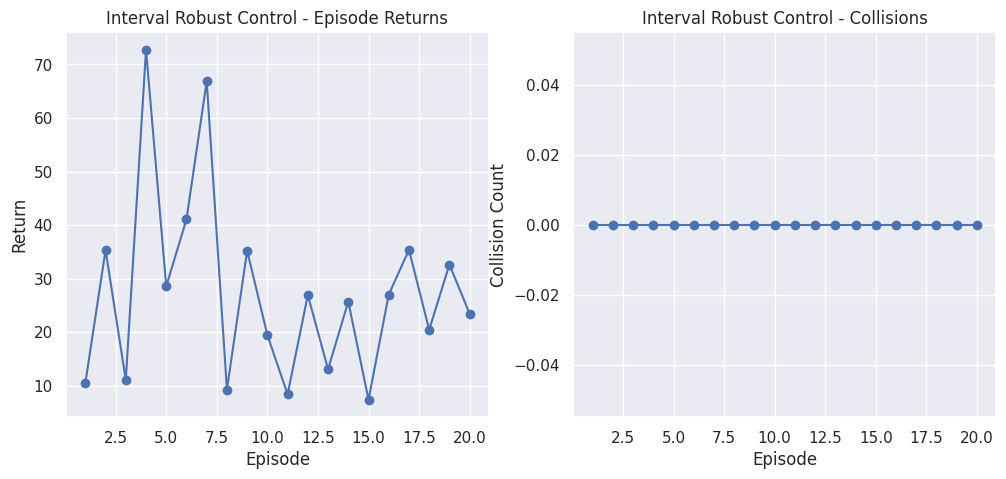

In [ ]:
run_and_dashboard(
    make_env_fn=lambda: IntervalWrapper(lambda t: make_env(noise_std=t), 0.0, 0.1),
    planner=interval_planner,
    episodes=20,
    max_steps=200,
    model_name="Interval Robust Control"
)

**Video Demo:** Visualizes a successful episode using the video recorder.

In [ ]:
record_and_show_successful_episode(
    make_env_fn=lambda: MetricOverlayWrapper(
        IntervalWrapper(lambda t: make_env(noise_std=t), 0.0, 0.1)),
    planner      = interval_planner,
    video_folder = "videos_interval",
    max_steps    = 200,
    max_tries    = 5
)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/HighwayEnv/scripts/videos_interval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[Attempt 1] Crashed at step 77, retrying...
[Attempt 2] Crashed at step 13, retrying...
[Attempt 3] Crashed at step 70, retrying...
[Attempt 4] Crashed at step 25, retrying...
[Attempt 5] Crashed at step 37, retrying...


# **Extension 3.1:** Adaptive Uncertainty Quantification

**Trains a neural network** to estimate return uncertainty from a flattened state

In [ ]:
# Simple MLP with dropout to estimate return uncertainty
class UncertaintyNet(nn.Module):
    def __init__(self, input_dim, hidden=64, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

Collect a small dataset of (obs → return) pairs via random rollouts

In [ ]:
env = make_env(noise_std=0.1)

data_X, data_y = [], []
for _ in range(50):
    o = env.reset()[0]; done=False; total=0
    while not done:
        a = env.action_space.sample()
        o, r, term, trunc, _ = env.step(a)
        total += r
        done = term or trunc
    data_X.append(o.flatten())
    data_y.append(total)

X = torch.tensor(data_X, dtype=torch.float32)
y = torch.tensor(data_y, dtype=torch.float32).unsqueeze(1)

Train the dropout network

In [ ]:
model = UncertaintyNet(X.shape[1])
opt   = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(100):
    pred = model(X)
    loss = nn.MSELoss()(pred, y)
    opt.zero_grad(); loss.backward(); opt.step()
adaptive_planner = RandomPlanner(env_fn=lambda: make_env(noise_std=0.1))

**Executes the planner** in a moderately noisy environment

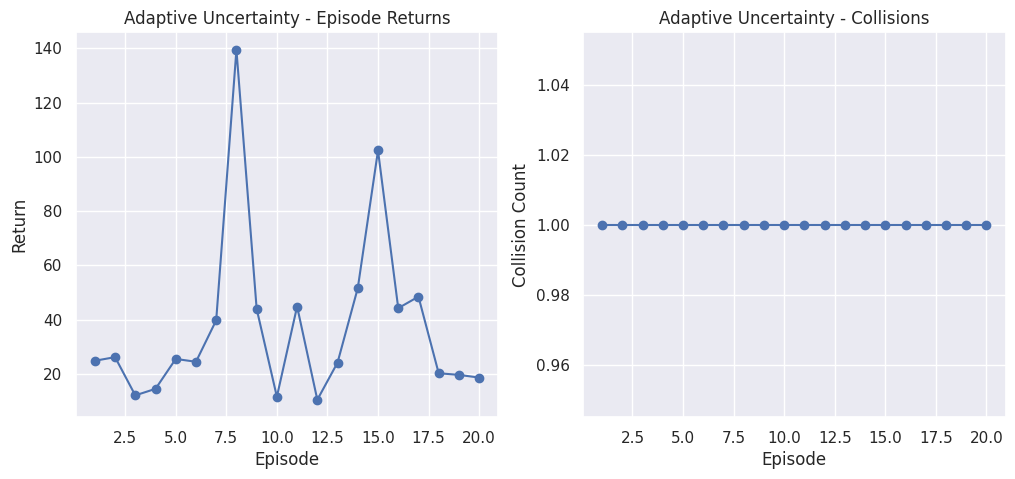

In [ ]:
run_and_dashboard(
    make_env_fn=lambda: MetricOverlayWrapper(make_env(noise_std=0.1)),
    planner=adaptive_planner,
    episodes=20,
    max_steps=200,
    model_name="Adaptive Uncertainty"
)

**Video Demo:** Visualizes a successful episode using the video recorder.

In [ ]:
record_and_show_successful_episode(
    make_env_fn    = lambda: MetricOverlayWrapper(make_env(noise_std=0.1)),
    planner        = adaptive_planner,
    video_folder   = "videos_ext1",
    max_steps      = 200,
    max_tries      = 10
)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/HighwayEnv/scripts/videos_ext1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[Attempt 1] Crashed at step 35, retrying...
[Attempt 2] Crashed at step 91, retrying...
[Attempt 3] Crashed at step 31, retrying...
[Attempt 4] Crashed at step 29, retrying...
[Attempt 5] Crashed at step 25, retrying...
[Attempt 6] Crashed at step 49, retrying...
[Attempt 7] Crashed at step 26, retrying...
[Attempt 8] Crashed at step 26, retrying...
[Attempt 9] Crashed at step 69, retrying...
[Attempt 10] Crashed at step 26, retrying...


# **Extension 3.2:** Hierarchical Hybrid Approach

**Implements a hybrid planner** that switches between high-level DROP planning every 5 steps and simple velocity-based rules

In [ ]:
class HierarchicalHybridPlanner:
    def __init__(self, make_env_fn, high_horizon=3, low_horizon=1):
        self.high_planner = DeterministicRobustOptimisticPlanner(
            make_env_fn=make_env_fn,
            horizon=high_horizon,
            budget=100,
            gamma=0.9,
            thetas=[0.0, 0.05, 0.1]
        )

In [ ]:
def act(self, obs, step):
    # every 5 steps do a high-level DROP action
    if step % 5 == 0:
        self.next_high = self.high_planner.act(obs)
    # between high decisions, use a simple interval‐based rule:
    # if current velocity < threshold, choose ACCELERATE (action 2), else DECELERATE (action 0)
    vel = obs[0,3]
    return self.next_high if step % 5 == 0 else (2 if vel<0.5 else 0)
HierarchicalHybridPlanner.act = act

**Executes the planner** in a moderately noisy environment

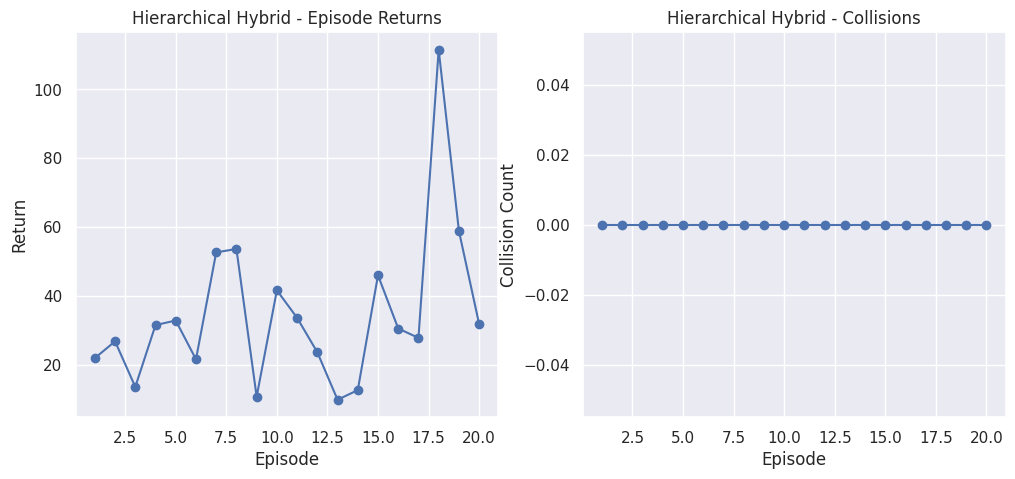

In [ ]:
hier_planner = HierarchicalHybridPlanner(lambda θ=None: make_env(noise_std=0.05))
run_and_dashboard(
    make_env_fn=lambda: make_env(noise_std=0.05),
    planner=hier_planner,
    episodes=20,
    max_steps=200,
    model_name="Hierarchical Hybrid"
)

**Video Demo:** Visualizes a successful episode using the video recorder.

In [ ]:
hier_planner = HierarchicalHybridPlanner(lambda θ=None: make_env(noise_std=0.05))
record_and_show_successful_episode(
    make_env_fn    = lambda: MetricOverlayWrapper(make_env(noise_std=0.05)),
    planner        = hier_planner,
    video_folder   = "videos_ext2",
    max_steps      = 250,
    max_tries      = 1
)

[Attempt 1] Crashed at step 40, retrying...


# **Extension 3.3:** Policy-Conditioned Uncertainty

Q-network with dropout to estimate uncertainty in action values

In [ ]:
class QNetDrop(nn.Module):
    def __init__(self, input_dim, hidden=64, dropout=0.5, n_actions=5):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.head = nn.Linear(hidden, n_actions)
    def forward(self, x):
        return self.head(self.base(x))

Selects actions using lower confidence bounds (LCB)

In [ ]:
class PolicyConditionedUncPlanner:
    def __init__(self, make_env_fn, q_net, samples=20):
        self.env      = make_env_fn(0.05)
        self.q_net    = q_net
        self.samples  = samples

In [ ]:
def act(self, obs):
    inp = torch.tensor(obs.flatten(), dtype=torch.float32).unsqueeze(0)
    self.q_net.train()
    qs = torch.stack([self.q_net(inp) for _ in range(self.samples)])  # [S,1,A]
    mean_q = qs.mean(0)
    std_q  = qs.std(0)
    # Lower confidence bound: μ − 1.96σ
    lcb    = mean_q - 1.96*std_q
    return int(lcb.argmax())
PolicyConditionedUncPlanner.act = act

## Q-Net Training

In [ ]:
# Hyperparams
gamma = 0.9
episodes = 200
batch_size = 64
learning_rate = 1e-3

In [ ]:
# Initialize Q-network and optimizer
q_net = QNetDrop(
    input_dim=env.observation_space.shape[0] * env.observation_space.shape[1],
    hidden=64, dropout=0.5, n_actions=env.action_space.n
)
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)
loss_fn   = nn.MSELoss()

# Experience buffer
buffer = deque(maxlen=10000)

In [ ]:
# Collect random-policy data
for ep in range(episodes):
    o = env.reset()[0]; done=False
    while not done:
        a = env.action_space.sample()
        no, r, term, trunc, _ = env.step(a)
        done = term or trunc
        buffer.append((o.flatten(), a, r, no.flatten(), done))
        o = no

In [ ]:
for epoch in range(200):
    if len(buffer) < batch_size: continue
    batch_idx = np.random.choice(len(buffer), batch_size, replace=False)
    obs_b   = torch.tensor([buffer[i][0] for i in batch_idx], dtype=torch.float32)
    act_b   = torch.tensor([buffer[i][1] for i in batch_idx], dtype=torch.long)
    rew_b   = torch.tensor([buffer[i][2] for i in batch_idx], dtype=torch.float32)
    next_b  = torch.tensor([buffer[i][3] for i in batch_idx], dtype=torch.float32)
    done_b  = torch.tensor([buffer[i][4] for i in batch_idx], dtype=torch.float32)

    # Current Q
    q_vals = q_net(obs_b)
    q_taken = q_vals.gather(1, act_b.unsqueeze(1)).squeeze(1)

    # Target Q
    with torch.no_grad():
        next_q = q_net(next_b)
        max_next_q = next_q.max(1)[0]
        target_q = rew_b + gamma * max_next_q * (1 - done_b)

    loss = loss_fn(q_taken, target_q)
    optimizer.zero_grad(); loss.backward(); optimizer.step()

print("Q-net training complete → last loss:", loss.item())

Q-net training complete → last loss: 12.747966766357422


## Evaluation & Video Demo

Instantiation with the trained Q-network and evaluation environment

In [ ]:
q_net  = QNetDrop(
    input_dim=env.observation_space.shape[0]*env.observation_space.shape[1],
    n_actions=env.action_space.n
)
env_pc = make_env(noise_std=0.05)
planner_pc = PolicyConditionedUncPlanner(lambda θ: make_env(noise_std=θ), q_net)


**Executes the planner** in a moderately noisy environment

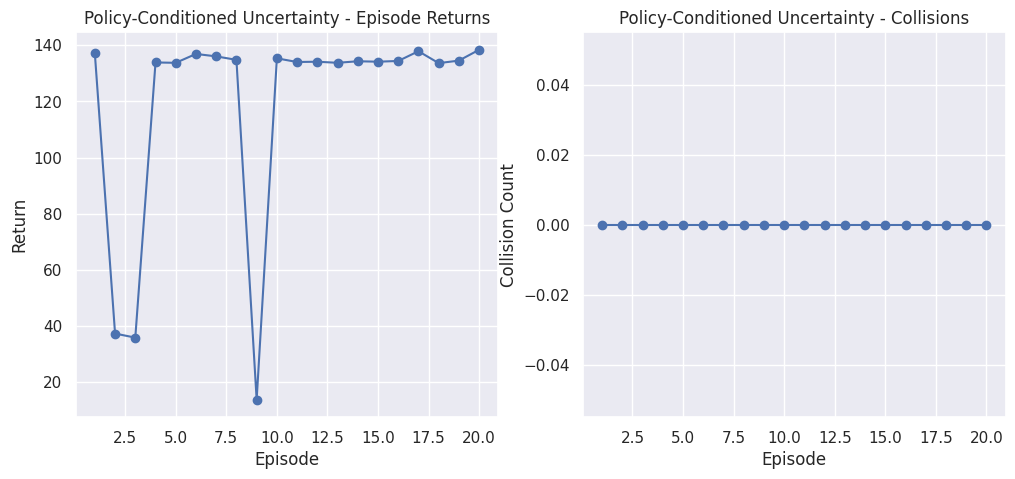

In [ ]:
pcu_planner = PolicyConditionedUncPlanner(lambda θ=None: make_env(noise_std=0.05), q_net)
run_and_dashboard(
    make_env_fn=lambda: make_env(noise_std=0.05),
    planner=pcu_planner,
    episodes=20,
    max_steps=200,
    model_name="Policy-Conditioned Uncertainty"
)

**Video Demo:** Visualizes a successful episode using the video recorder.

In [ ]:
pcu_planner = PolicyConditionedUncPlanner(lambda θ=None: make_env(noise_std=0.05), q_net)
record_and_show_successful_episode(
    make_env_fn = lambda: MetricOverlayWrapper(make_env(noise_std=0.05)),
    planner     = pcu_planner,
    video_folder= "videos_ext3",
    max_steps   = 200,
    max_tries   = 1
)

NameError: name 'PolicyConditionedUncPlanner' is not defined